## C S 329E HW 9

# Clustering with K-means 

## Jeremy Ulfohn, Pair 42

For this week's homework we are going explore our first clustering method:

  - K-Means
  
As we discussed in lecture, k-means creates clusters based on a distance measure.  Using a small example data set, we will implement the algorithm and visualize the results.

Even though the example data is small and 2 dimensional, write your helper functions to not assume a 2-D data set.  Your plotting code can reference the `x` and `y` column names from the sample data directly. 

Note that I have added a one or two lines of code to the questions to test your implementation. 

In [103]:
# Do not import anything else
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# K-Means

We will implement the Algorithm 7.1 "Basic K-means", and apply that algorithm to a small data set provided with the assignment in the `data_kmeans.csv` file. We will build up some helper functions along the way, test them, and put it all together to apply to our small example data set. 

In [104]:
# loading in our toy data
df_kmeans = pd.read_csv("https://gist.githubusercontent.com/TieJean/ff4dbd0022ab5e292db73d8b4910f551/raw/624db21e20faa92b79e5289ce4d9002e863b0d68/data_kmeans.csv")
df_kmeans.head() # 450 rows, 2 col

,x,y
0,-0.731698,-0.874311
1,-0.547702,-0.580320
2,-0.762840,-0.885572
3,-0.340946,-0.810411
4,-0.749065,-0.399218


## Q1 - Write a function that returns `k` random rows from a data frame

To initialize the centroids, we pick `k` random points from a data frame.  Write a function `init_centroids( df_data, k )` that accepts two parameters: a data frame `df_data`, and an integer `k`, and returns the initial centroids for our k-means algorithm.  Note, we want the indices of the returned data frame to range from 0 - (k-1) so that we can use these as the centroid labels.  Use [pandas sample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) method, and pass it the value of $42$ for `random_state`. 

In [105]:
def init_centroids( df_data, k ):
    # get k random rows from df_data.iterrows()
    # indices range from [0, k-1], so use .reset_index(drop=True)
    return df_data.sample(n=k, random_state=42, axis=0).reset_index(drop=True)



In [106]:
# Testing our init centroid function
df_centroids = init_centroids( df_kmeans, 7 )
df_centroids

,x,y
0,-0.633437,0.488756
1,-0.597736,0.632194
2,-0.635867,0.166613
3,-0.539351,-0.875532
4,-0.588597,0.293062
5,-0.127985,-0.136639
6,0.342579,0.211717


## Q2 - Write a function to assign every row in a data frame to a centroid 

Write a function, `assign_to_centroid`, that accepts two parameters: a data frame, `df_data`, that represents our data to be clustered, and the data frame, `df_centroids`, which is of length `k` and contains the current centroids for our clusters.  The functions returns a series of the same length of `df_data` that contains the index of the closest centroid in `df_centroid`.  Use Euclidean distance as your distance measure. 

For example, if a row of data contained the data point $(100,123)$ and the three centroids were in a data frame that had the following information:

  - Index 0 : (34,34)
  - Index 1 : (0,1)
  - Index 2 : (83,99)

The `assign_to_centroid` function would assign the index $2$ to that row of data. 

In [107]:
# OUTPUT: pd.Series of same length as df_data that contains...
# ...indices of closest centroid in df_centroids
def assign_to_centroid( df_data, df_centroids ):
    # nested helper function to handle each row of df_data
    def get_closest_centroid_index(data_row):
        dist_tuples = [] # list of (ind, dist) of which to find minimum

        # FIXME: this loop is fucked up
        for index, row in df_centroids.iterrows():
            a = np.array(data_row)
            b = np.array(row)
            euclidean = np.linalg.norm(a - b)
            dist_tuples.append((index, euclidean))
        
        # now find and return minimum INDEX OF EUCLIDEAN DIST of dist_tuples
        return min(dist_tuples, key = lambda t: t[1])[0]

    closest_centroids = [] # initialize output

    # get euclidean_dist between each point and centroid
    # find minimum (closest centroid) and get index thereof
    for index, row in df_data.iterrows():
        closest_centroids.append(get_closest_centroid_index(row))
    
    return pd.Series(closest_centroids) # return pd.Series version
    

In [154]:
# Check how many data points were assigned to each centroid
# checked: len == df_data_len == 450
s_centroid_assignment = assign_to_centroid( df_kmeans, df_centroids )
s_centroid_assignment.value_counts()

6    126
1     94
3     71
5     58
0     53
2     26
4     22
dtype: int64

## Q3 - Write a function that recomputes the centroids

Write a function `compute_centroids` that takes two parameters: the data frame, `df_data` containing the data being clustered, and a series of the same length that contains the label of the assigned centroid for every row in df_data, `s_centroid_assignment`. The function will return the a data frame containing the centroids (mean) value for each unique centroid. 

Note that the indices in the returned data frame should correspond to the unique values in `s_centroid_assignment`.  For example, if I found the mean value of df_data using the slice corresponding to `s_centroid_assigment == 2`, then the centroid should be in the returned data frame at `.iloc[2]`. 


In [109]:
# Helper function; takes pd.Series and value for occurence indices
def get_indices_where(series, test_k):
    indices = []
    for index, value in series.items():
        if value == test_k:
            indices.append(index)
    return indices
    

In [151]:
# INPUT: df_data, s_centroid_assignment: pd.Series containing centroid label
# OUTPUT: pd.Dataframe containing mean df_data value FOR each centroid
# i.e. it will have index [0, 6, ++] and col 'x' and 'y'
def compute_centroids( df_data, s_centroid_assignment ):
    null_dict = dict() # keys 0 through 6

    # (1) slice df_data where s_centroid_assignment == 0, ==1, etc.
    # FIXME: this always uses k :== 7!!!
    for current_k in range(s_centroid_assignment.max()+1): # df_centroids is same as kval
        # get indices in s_centroid_assignment where k == current_k
        indices = get_indices_where(s_centroid_assignment, current_k)
        
        # now get 'x' and 'y' averages from df_data AT these indices (slices)
        null_dict[current_k] = []
        for col in df_data:
            # add dict entry at this k
            null_dict[current_k].append(df_data.iloc[indices][col].mean())

    # finally, convert null_dict to df
    return pd.DataFrame.from_dict(null_dict, orient='index', columns=['x', 'y'])
    

In [111]:
# Test it out
df_new_centroids = compute_centroids( df_kmeans, s_centroid_assignment)
df_new_centroids

,x,y
0,-0.715983,0.500552
1,-0.721574,0.708343
2,-0.738268,-0.113830
3,-0.696694,-0.699028
4,-0.546913,0.321364
5,-0.102365,-0.188876
6,0.523364,0.238569


## Q4 - Write a function that compares two centroid data frames

The stopping criterion for k-means is when our centroids have not moved since the last iteration.  Write a function `compare_centroids` that is given 2 centroid data frames, `df_centroid_a`, and `df_centroid_b` as parameters and returns `True` or `False` indicating if the centroids at each unique index in the data frame are equal. Use the [equals](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.equals.html) method to compare equality of pandas Series objects. 

In [112]:
def compare_centroids( df_centroid_a, df_centroid_b ):
    return df_centroid_a.equals(df_centroid_b) # pd..equals() can be on df or s

In [113]:
# Test it out, should print True followed by False
print(compare_centroids( df_new_centroids, df_new_centroids ))
print(compare_centroids( df_new_centroids, df_centroids ))

True
False


## Q5 - Write a function that implements k-means

Write a function, `k_means`, that takes in as parameters 2 values, a data frame with values to cluster, `df_data`, and the number of clusters to form, `k`.  The function should return a series of data of the same length as `df_data` that contains the cluster assignment (an integer from 0 to (k-1)) for each row of data.  Use the helper functions defined in the prior questions. 

In [114]:
# OUTPUT: pd.Series (homomagnitudinal) 
def k_means( df_data, k ):
    # 1) choose k random points as centroids_0, and assign first cluster set
    df_centroids = init_centroids( df_data, k )

    # begin loop after null case
    # FIXME: this is where it's implied that k == 7. check assign_to_centroid()
    new_s_centroid_assignment = assign_to_centroid( df_data, df_centroids )

    # 2) update centroid of each cluster based on mean
    df_new_centroids = compute_centroids(df_data, new_s_centroid_assignment)

    # LOOP: 3) recluster points by closest centroid
    #       4) repeat steps until compare_centroids = True, True
    while not compare_centroids(df_centroids, df_new_centroids):
        df_centroids = df_new_centroids
        new_s_centroid_assignment = assign_to_centroid( df_data, df_centroids )
        df_new_centroids = compute_centroids(df_data, new_s_centroid_assignment)

    # s_centroid_assignment (df of cluster assignments) is now finalized
    return new_s_centroid_assignment








In [149]:
# Call k_means with k = 5 to test
new_s_cluster_assignment = k_means( df_kmeans, 5)
new_s_cluster_assignment.value_counts()

0    178
3     89
2     74
4     63
1     46
dtype: int64

## Q6 - Plot the results

Plot the points in the `df_kmeans` data frame using a 2-D scatter plot, with a different color for each cluster.  Use the cluster assignments from the previous problem (`s_cluster_assignments`).  Label your axes, and give the plot a title. 

Text(0, 0.5, 'Y Value')

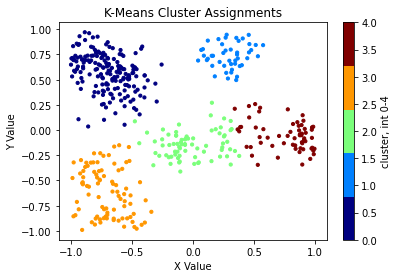

In [148]:
# GOAL: Plot each cluster

# concatenate new_s_cluster_assignment onto df_means
df_to_plot = pd.concat([df_kmeans, new_s_cluster_assignment], axis=1)
df_to_plot.columns.values[2] = "cluster, int 0-4" # rename col by index with .values[]

# use matplotlib.pyplot :== plt
fig, ax = plt.subplots()
cmap = plt.get_cmap('jet', 5)
df_to_plot.plot(kind='scatter', x='x', y='y', s=10, c='cluster, int 0-4', colormap=cmap, ax=ax)
# title and axis labels
plt.title("K-Means Cluster Assignments")
plt.xlabel("X Value")
plt.ylabel("Y Value")

 